# Sentiment Analysis for Prediction of Wine Ratings


## Sentiment Analysis: 
I used the `nltk.sentiment.vader.SentimentIntensityAnalyzer` on the wine description.

## Conclusions: 
The sentiment analysis is sleek, but not always as accurate as I've seen in other uses. An exmaple output for a bad wine, which despite using "mucky" and "compost-like nose", had zero negative sentiment. 
```
{'neg': 0.0, 'neu': 0.789, 'pos': 0.211, 'compound': 0.802} (score = 80) 
This is mucky and sweet. Its best foot is not put forward via the compost-like nose, and from then on there's little more than prune, leather and a sticky mouthfeel.
```
The sentiment analysis provides useful features for predictive modeling, but by itself is less useful than the word-based model from the other notebook. Future work could combine these features. 


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Natural Language processing
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Machine Learning 
from sklearn.ensemble import RandomForestRegressor

# Interpretation of model results
import shap

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## NLTK Vader Sentiment Analysis

In [2]:
df_raw = pd.read_csv('../input/winemag-data_first150k.csv')
df_raw.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [3]:
def nltk_vader_sentiment_feature_extraction(df, feature:str):
    """
    Add features for dimensions of the nltk Vader sentiment scores
    Note - There's likely a more efficient way than refitting sid each time
    However, my other mapping way was far longer than the roughly linear scaling here
    """
    # Sentiment Analyzer
    sid = SentimentIntensityAnalyzer()
    df[f'{feature}_sent'] = df[feature].apply(lambda x: sid.polarity_scores(x))
    
    #Extract component measures
    for measure in ['compound', 'pos', 'neg', 'neu']:
        df[f'{feature}_sent_{measure}'] = df[f'{feature}_sent'].apply(lambda x: x[measure])
        
    # Derive additional features
    df[f'{feature}_sent_abs'] = np.abs(df[f'{feature}_sent_compound'])
    df[f'{feature}_sent_strength'] = df[f'{feature}_sent_pos'] + np.abs(df[f'{feature}_sent_neg'])
    return df

In [4]:
%%time
df = nltk_vader_sentiment_feature_extraction(df_raw, 'description')

Wall time: 1min 12s


In [5]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,description_sent,description_sent_compound,description_sent_pos,description_sent_neg,description_sent_neu,description_sent_abs,description_sent_strength
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,"{'neg': 0.0, 'neu': 0.768, 'pos': 0.232, 'comp...",0.9287,0.232,0.0,0.768,0.9287,0.232
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,"{'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'comp...",0.7311,0.135,0.0,0.865,0.7311,0.135
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,"{'neg': 0.0, 'neu': 0.858, 'pos': 0.142, 'comp...",0.8070,0.142,0.0,0.858,0.8070,0.142
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,"{'neg': 0.0, 'neu': 0.97, 'pos': 0.03, 'compou...",0.2023,0.030,0.0,0.970,0.2023,0.030
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,"{'neg': 0.0, 'neu': 0.89, 'pos': 0.11, 'compou...",0.7717,0.110,0.0,0.890,0.7717,0.110


In [6]:
# highest scoring reviews reviews: 
rows = df.sort_values('points')[-5:]
for idx in rows.index:
    row = rows.loc[idx]
    print(str(row.description_sent) + " (score = " + row['points'].astype(str) + ') \n' + row.description + '\n')

{'neg': 0.025, 'neu': 0.898, 'pos': 0.077, 'compound': 0.6369} (score = 100) 
Thick as molasses and dark as caramelized brown sugar, the wine oozes out of the bottle releasing concentrated aromas of butterscotch, toffee, honey, licorice, coffee, resin and maple syrup. Grapes from the Montepulciano area are dried in a ventilated room and the wine ages over 10 years in tiny oak barrels resulting in thick, dark concentration. Don't pair it with food: Vin Santo as good as this deserves to be enjoyed alone, as a so-called “meditation wine.”

{'neg': 0.0, 'neu': 0.786, 'pos': 0.214, 'compound': 0.9819} (score = 100) 
A perfect score has to be considered in the context of its region. Shafer's 2004 Hillside Select is tremendous as a Napa Valley Cabernet Sauvignon that competes with its peers at the highest levels. It's always a fabulous wine, but in warm 2004, Shafer's amphitheater vineyard sheltered the grapes, ripening them to perfection yet protecting the “iron fist in a velvet glove” struc

In [7]:
# Lowest scoring reviews reviews: 
rows = df.sort_values('points')[:5]
for idx in rows.index:
    row = rows.loc[idx]
    print(str(row.description_sent) + " (score = " + row['points'].astype(str) + ') \n' + row.description + '\n')

{'neg': 0.127, 'neu': 0.743, 'pos': 0.13, 'compound': 0.0223} (score = 80) 
Smells like canned fruit, and tastes like greens along with mealy pineapple. Falls apart on the finish. Not recommended but not lethal. Barely acceptable.

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} (score = 80) 
There's something not right about the way this winery is fermenting its Cavas because both this and Oriol Rossell's regular brut are excessively foamy. As a result, this gran reserva's apple and spice aromas and flavors are rendered moot by the gaseous explosion that occurs when liquid hits palate.

{'neg': 0.0, 'neu': 0.789, 'pos': 0.211, 'compound': 0.802} (score = 80) 
This is mucky and sweet. Its best foot is not put forward via the compost-like nose, and from then on there's little more than prune, leather and a sticky mouthfeel.

{'neg': 0.152, 'neu': 0.795, 'pos': 0.052, 'compound': -0.5834} (score = 80) 
Eight grapes comprise this weird, peanutty, almost dirty red blend. The nose is 

## Correlations with score

In [10]:
df_plot = df.sample(10_000)  # subset for speed

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


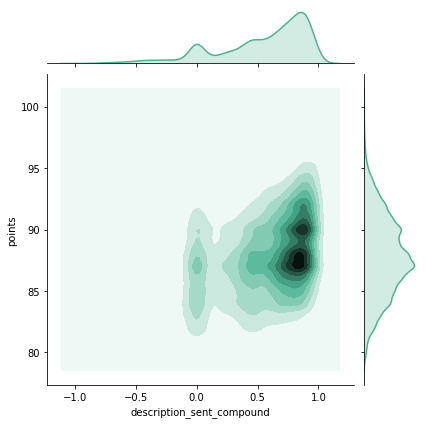

In [11]:
sns.jointplot(df_plot.description_sent_compound, df_plot.points, kind="kde", color="#4CB391") 

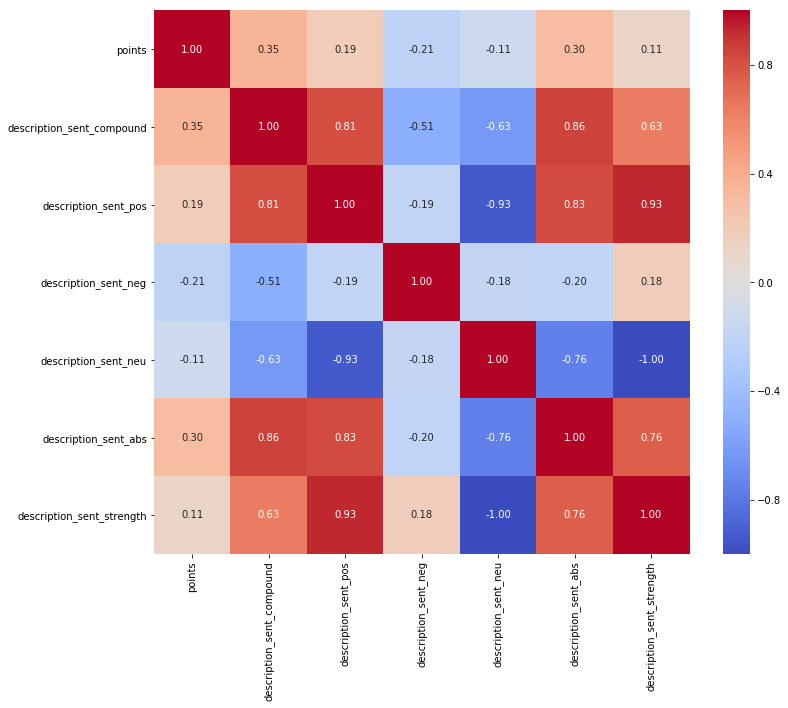

In [12]:
features = [c for c in df.columns if '_sent' in c]
cols = ['points'] + features 
corr = df_plot[cols].corr()
plt.figure(figsize=[12,10])
g = sns.heatmap(corr, annot=True, fmt = ".2f", cmap = "coolwarm", center=0)

## Build Random Forest with the very limited features
Not bothering to do validation, etc

In [13]:
features.remove('description_sent')
X_train = df[features]
y_train = df['points']

In [14]:
rf = RandomForestRegressor(max_depth=4, n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

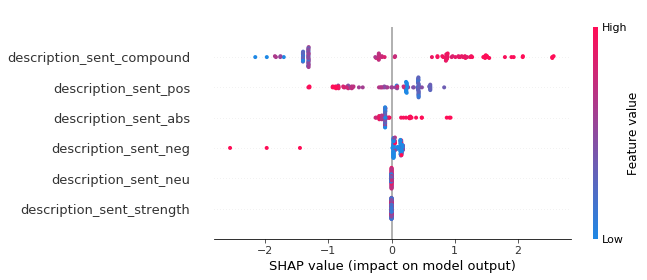

In [15]:
df_subset = X_train.sample(100, random_state=42)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(df_subset)
shap.summary_plot(shap_values, df_subset, max_display=30)